## Plot MTM results for carbon

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
from scipy import stats
import pandas as pd
import scipy
import math
from tqdm.notebook import tqdm

In [2]:
# Load MTM result

OTMrun='true'
CO2flux_prior = True

yr_init=1992

Opt_result = xr.open_mfdataset(OTMrun+'_transports.nc')

Basins = Opt_result.Basins
tree_depth=int(math.log2(Opt_result.tree_depth))

month_init_early=(Opt_result.init_early-yr_init)*12
month_init_late=(Opt_result.init_late-yr_init)*12
Early_period = (np.array([month_init_early,month_init_early+Opt_result.dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+Opt_result.dyrs*12]))

dt = Opt_result.dt.values
dyrs = Opt_result.dyrs.astype('float64')

In [3]:
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients

# Establish basic constants 
yr2sec = 365.25*24*60*60
Cp=4000
rho=1029
S0=35

In [4]:
## Load BSP data

ECCO_BSP_data = xr.open_mfdataset(('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/tree_depth_6_BSP_ECCO/9_Basins_fluxerr_6/BSP_ECCO_monthly_*'))
    
## Early Period
Part_early = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
C_early = ECCO_BSP_data.C_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')                                 
V_early = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
# Asection_early = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
C_late = ECCO_BSP_data.C_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
# Asection_late = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ECCO_BSP_data.Basin.values
# Sections = ACCESS_BSP_data.Section.values

ECCO_time = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/ECCO-Darwin/ECCO_time.nc')
ECCO_dt=(np.hstack([ECCO_time.ECCO_time[0].values,np.diff(ECCO_time.ECCO_time)])).reshape(1,323,1)
ECCO_dt=ECCO_dt[:,0:ECCO_BSP_data.Time.size,:]



In [5]:
# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
C_1 = C_early.values.flatten()
C_2 = C_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

if CO2flux_prior:
    
    dC_Cflux = Opt_result.dC_Cflux
    dC_Cflux[np.isnan(dC_Cflux)] = 0
    dC_Cflux[~np.isfinite(dC_Cflux)] = 0
    
    C_1 = C_early.values.flatten() + dC_Cflux

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0
C_1[np.isnan(C_1)] = 0
C_2[np.isnan(C_2)] = 0

### Calculate section transports

In [6]:
# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
d_ij = np.zeros((Basins.size,Basins.size))


d_ij[0,:] = [1, -1, 0, 0, 0, 0, 0, -1, 0]
d_ij[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
d_ij[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
d_ij[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
d_ij[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
d_ij[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
d_ij[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
d_ij[7,:] = [1, 0, 0, 0, 0, 0, -1, 1, 0]
d_ij[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: d_ij.T[0,:],\
    Basins[1]: d_ij.T[1,:],\
    Basins[2]: d_ij.T[2,:],\
    Basins[3]: d_ij.T[3,:],\
    Basins[4]: d_ij.T[4,:],\
    Basins[5]: d_ij.T[5,:],\
    Basins[6]: d_ij.T[6,:],\
    Basins[7]: d_ij.T[7,:],\
    Basins[8]: d_ij.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table


,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
Subtropical N. Atlantic,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0,0.0
N. Pacific,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [7]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))

for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(dt*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] # Sv

int_section_trans = np.zeros((Basins.size, Basins.size))
int_section_trans_C = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[V_early.shape[1]*i:(V_early.shape[1]*(i+1)),V_early.shape[1]*j:(V_early.shape[1]*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))
section_trans_C_temp = np.zeros((Vol_1.size, Basins.size))
for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

In [8]:
basin_connex = np.array([[0,1],
                [1,2],
                [2,3],
                [3,8],
                [4,8],
                [4,6],
                [5,8],
                [6,5],
                [7,6],
                [0,7]]).astype(int)


T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
C_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    C_joined[i,:] = np.concatenate([C_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],C_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])
    


In [9]:
# Check Bering Strait transports

display(int_section_trans[0,7]) # (Southwards)
display(int_section_trans[7,0]) # (Northwards)


0.0

1.0999999998952743

#### Plot section volume transports

Text(0.5, 1.0, 'Section Transport (Sv)')

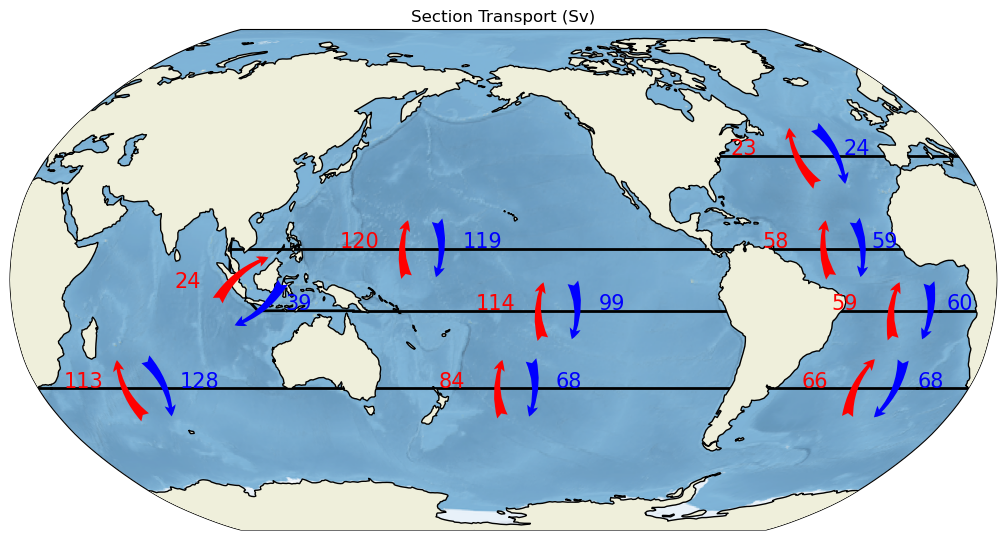

In [10]:
fig  = plt.figure(1, figsize = (15, 6.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)
fs = 15

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.add_feature(cfeature.LAND, zorder=100)

## S PAC <> SO

ax1.annotate('', xy=(200,-25), xytext=(200, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[5,-1]))), xy=(200,-25), xytext=(220, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(210,-45), xytext=(210, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(np.round(int_section_trans[-1,5])), xy=(175,-25), xytext=(175, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

## EQ PAC <> S PAC

ax1.annotate('', xy=(215,0), xytext=(215, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[6,5]))), xy=(235,-9.5), xytext=(235, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(225,-20), xytext=(225, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(np.round(int(int_section_trans[5,6])), xy=(190,-9.5), xytext=(190, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

## EQ PAC <> N PAC

ax1.annotate('', xy=(165,20), xytext=(165, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[7,6]))), xy=(185,10.5), xytext=(185, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(175,0), xytext=(175, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[6,7]))), xy=(140,10.5), xytext=(140, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

## IND <> SO

ax1.annotate('', xy=(55,-25), xytext=(55, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(np.round(int_section_trans[4,-1]))), xy=(75,-25), xytext=(75, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(65,-45), xytext=(65, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(np.round(int_section_trans[-1,4])), xy=(30,-25), xytext=(30, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

## EQ PAC <> IND

ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[6,4]))), xy=(75,-9.5), xytext=(120, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(100, -15), xytext=(120,0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(np.round(int_section_trans[4,6])), xy=(80,-2.5), xytext=(80, -2.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)


## S ATL <> SO

ax1.annotate('', xy=(340,-25), xytext=(340, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[3,-1]))), xy=(360,-25), xytext=(360, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(350,-45), xytext=(350, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(np.round(int_section_trans[-1,3])), xy=(315,-25), xytext=(315, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

## EQ ATL <> S ATL

ax1.annotate('', xy=(345,0), xytext=(345, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[2,3]))), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(355,-20), xytext=(355, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(np.round(int_section_trans[3,2])), xy=(320,-9.5), xytext=(320, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

## EQ ATL <> ST ATL

ax1.annotate('', xy=(320,20), xytext=(320, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[1,2]))), xy=(335,10.5), xytext=(335, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(330,0), xytext=(330, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[2,1]))), xy=(295,10.5), xytext=(295, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

## ST ATL <> POL ATL

ax1.annotate('', xy=(320,50), xytext=(320, 30),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(np.round(int_section_trans[0,1]))), xy=(335,40.5), xytext=(335, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=fs, zorder=103)

ax1.annotate('', xy=(330,30), xytext=(330, 50),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(np.round(int_section_trans[1,0]))), xy=(290,40.5), xytext=(290, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=fs, zorder=103)

plt.title('Section Transport (Sv)')
#plt.savefig(OTMrun+'_volume_transport.png', bbox_inches='tight', dpi=300, transparent=True)


### Carbon budget

In [11]:
## Calculate integral of carbon budget terms from MTM solution

C_trans = C_joined*section_joined*10**6*yr2sec/(10**18/12) # PgC/yr
CF_section_tot = np.nansum(C_trans, axis=-1)

Cint_early = ((ECCO_BSP_data.C_mean_hist)*ECCO_BSP_data.V_sum_hist).isel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # mmol-C
Cint_late = ((ECCO_BSP_data.C_mean_hist)*ECCO_BSP_data.V_sum_hist).isel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # mmol-C

Cflux_early = ((ECCO_BSP_data.Cflux_sum_hist)*ECCO_dt).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Early_period[0],Early_period[1])).mean('Time').sum('Depth') # mmol-C
Cflux_late = ((ECCO_BSP_data.Cflux_sum_hist)*ECCO_dt).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sel(Time=slice(Late_period[0],Late_period[1])).mean('Time').sum('Depth') # mmol-C

Cflux_input = ((Cflux_late-Cflux_early)/(dyrs*(10**18/12))).values # units: PgC/yr
Cint_change = ((Cint_late-Cint_early)/(dyrs*10**18/12)).values # units: PgC/yr

dC_adj_int = ((Opt_result.dC_adjustment.values.reshape(Basins.size,2**tree_depth)*V_late).sum(axis=1)/(dyrs*(10**18/12))).values # Note Taimoor says we should be multiplying by V_late (but V_early currently gives better results)
#dC_adj_int = ((Opt_result.dC_adjustment.values.reshape(Basins.size,2**tree_depth)*V_early).sum(axis=1)/(dyrs*(10**18/12))).values # If second optimisaton used

if CO2flux_prior:
    dC_Cflux_int = (np.reshape(dC_Cflux.values,(Basins.size,2**tree_depth))*V_early).sum(axis=1)/(dyrs.values*(10**18/12))
else:
    dC_Cflux_int = 0

In [12]:
CF_section_tot

array([-0.65339641, -0.6009174 , -0.49384532, -0.36644618, -4.55286522,
       -4.69545265,  5.27645543,  5.24807622, -0.14517347,  0.36659783])

Text(0.5, 1.0, 'Section Carbon Transport (Pg-C yr$^{-1}$)')

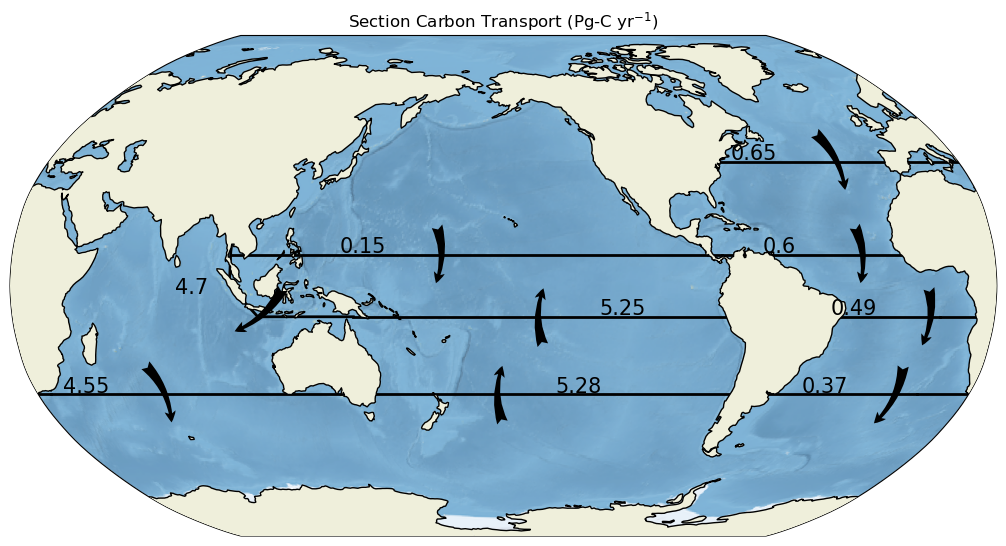

In [13]:
## Plot inter-basin carbon transports from MTM solution

fig  = plt.figure(1, figsize = (15, 6.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)
fs=15

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

#ax1.pcolormesh(lons, lats, np.nansum(OHU_remapped,axis=0), transform = ccrs.PlateCarree(), vmin=-50, vmax=50, cmap=plt.cm.bwr) (This won't work with the ECCO grid, pcolormesh expects 2D array)
ax1.add_feature(cfeature.LAND, zorder=100)
#cax = fig.add_axes([0.925, 0.12, 0.02, 0.8])
#m = plt.cm.ScalarMappable(cmap='bwr')
#m.set_clim(-50, 50)
#cbar = fig.colorbar(m, cax=cax, orientation='vertical')
#cbar.set_label('Rate of OHU (TW)')

## S PAC <> SO

if CF_section_tot[6]>0:
        ax1.annotate('', xy=(200,-25), xytext=(200, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[6]).round(2)), xy=(200,-25), xytext=(220, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(210,-45), xytext=(210, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[6]).round(2)), xy=(175,-25), xytext=(175, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ PAC <> S PAC
if CF_section_tot[7]>0:

        ax1.annotate('', xy=(215,0), xytext=(215, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[7]).round(2)), xy=(235,-9.5), xytext=(235, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(225,-20), xytext=(225, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[7]).round(2)), xy=(190,-9.5), xytext=(190, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ PAC <> N PAC
if CF_section_tot[8]>0:


        ax1.annotate('', xy=(165,20), xytext=(165, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[8]).round(2)), xy=(185,10.5), xytext=(185, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(175,0), xytext=(175, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[8]).round(2)), xy=(140,10.5), xytext=(140, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## IND <> SO
if CF_section_tot[4]>0:
        ax1.annotate('', xy=(55,-25), xytext=(55, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((CF_section_tot[4]).round(2)), xy=(75,-25), xytext=(75, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(65,-45), xytext=(65, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[4]).round(2)), xy=(30,-25), xytext=(30, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ PAC <> IND
if CF_section_tot[5]>0:
        ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[5]).round(2)), xy=(75,-9.5), xytext=(120, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(100, -15), xytext=(120,0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[5]).round(2)), xy=(80,-2.5), xytext=(80, -2.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)


## S ATL <> SO
if CF_section_tot[3]>0:

        ax1.annotate('', xy=(340,-25), xytext=(340, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[3]).round(2)), xy=(360,-25), xytext=(360, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(350,-45), xytext=(350, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[3]).round(2)), xy=(315,-25), xytext=(315, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ ATL <> S ATL
if CF_section_tot[2]>0:

        ax1.annotate('', xy=(345,0), xytext=(345, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[2]).round(2)), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(355,-20), xytext=(355, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[2]).round(2)), xy=(320,-9.5), xytext=(320, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## EQ ATL <> ST ATL
if CF_section_tot[1]>0:

        ax1.annotate('', xy=(320,20), xytext=(320, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[1]).round(2)), xy=(335,10.5), xytext=(335, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(330,0), xytext=(330, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[1]).round(2)), xy=(295,10.5), xytext=(295, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

## ST ATL <> POL ATL
if CF_section_tot[0]>0:

        ax1.annotate('', xy=(320,50), xytext=(320, 30),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((CF_section_tot[0]).round(2)), xy=(335,40.5), xytext=(335, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)
else:
        ax1.annotate('', xy=(330,30), xytext=(330, 50),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((CF_section_tot[0]).round(2)), xy=(290,40.5), xytext=(290, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=fs, zorder=103)

ax1.set_title('Section Carbon Transport (Pg-C yr$^{-1}$)')

#plt.savefig(OTMrun+'_carbon_transport.png', bbox_inches='tight', dpi=300, transparent=True)

In [14]:
## Calculate inter-basin carbon fluxes using model surface fluxes and interior changes

recalc_modtransp = False

if recalc_modtransp:

    # Load model CO2 and interior C*

    chunks = {'time': 1, 'k': 10}
    chunks2 = {'time': 12}
    chunks3 = {'k': 25, 'Basins': 1}

    filename = 'folders_ECCO.txt'
    with open(filename) as f:
        mylist = f.read().splitlines() 

    ECCO_CO2flux = xr.open_mfdataset(mylist[18], decode_times=True, decode_cf=True, chunks = chunks2)
    ECCO_sedflux = xr.open_mfdataset(mylist[21], decode_times=True, decode_cf=True, chunks = chunks2)
    ECCO_Cstar = xr.open_mfdataset(mylist[19], decode_times=True, decode_cf=True, chunks = chunks)

    ECCO_time = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/ECCO-Darwin/ECCO_time.nc')
    ECCO_dt=(np.hstack([ECCO_time.ECCO_time[0].values,np.diff(ECCO_time.ECCO_time)])).reshape(1,323,1)
    ECCO_dt=ECCO_dt[0,0:ECCO_BSP_data.Time.size,:,np.newaxis,np.newaxis]

    # Load basin mask

    ECCO_mask = xr.open_mfdataset(mylist[7], decode_times=True, chunks = chunks3)
    mask_2D = (ECCO_mask.mask_ECCO).isel(k=0)
    mask_2D=xr.where(mask_2D>=0.5,1,0)

    # Calculate cumulative integrals with latitude

    vol = ECCO_Cstar.rA*ECCO_Cstar.drF*ECCO_Cstar.hFacC*ECCO_Cstar.maskC

    CO2flux_mod = ((ECCO_CO2flux.fluxCO2*ECCO_dt-ECCO_sedflux.Cstar_flux*ECCO_dt).isel(time=slice(Early_period[0],Late_period[-1]))).sum('time')*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0])) # mmol-C/m^2
    Cchange_mod = ECCO_Cstar.Cstar.isel(time=slice(Late_period[0],Late_period[-1])).mean('time') - ECCO_Cstar.Cstar.isel(time=slice(Early_period[0],Early_period[-1])).mean('time') # mmol-C/m^3

    # Convert into mmol-C per lat/lon grid cell

    CO2flux_mod_int = CO2flux_mod*CO2flux_mod.rA*ECCO_Cstar.maskC[0,:,:,:] # mmol-C
    Cchange_mod_int = (Cchange_mod*vol).sum('k') # mmol-C
    
    ds = xr.Dataset()
    ds['Cchange_mod_int'] = Cchange_mod_int
    ds['CO2flux_mod_int'] = CO2flux_mod_int
    ds.to_netcdf('temp.nc')

    CO2flux_mod_int = xr.open_mfdataset('temp.nc').CO2flux_mod_int
    Cchange_mod_int = xr.open_mfdataset('temp.nc').Cchange_mod_int

    # Calculate meridional transports with latitude from cumulative integral of carbon budget from north to south

    mask_ATL = mask_2D.isel(Basins=[0,1,2,3]).sum('Basins')
    mask_INDPAC = mask_2D.isel(Basins=[4,5,6,7]).sum('Basins')

    latgrid=np.arange(-90,90)

    Ctransp_global=np.zeros(latgrid.size)
    Ctransp_ATL=np.zeros(latgrid.size)
    Ctransp_INDPAC=np.zeros(latgrid.size)


    for j in tqdm(range(latgrid.size)):
        Ctransp_global[j] = np.where(CO2flux_mod_int.YC>=latgrid[j],CO2flux_mod_int,np.zeros_like(CO2flux_mod_int)).sum() -             np.where(Cchange_mod_int.YC>=latgrid[j],Cchange_mod_int,np.zeros_like(Cchange_mod_int)).sum()
        Ctransp_ATL[j]    = np.where(CO2flux_mod_int.YC>=latgrid[j],CO2flux_mod_int*mask_ATL,np.zeros_like(CO2flux_mod_int)).sum() -    np.where(Cchange_mod_int.YC>=latgrid[j],Cchange_mod_int*mask_ATL,np.zeros_like(Cchange_mod_int)).sum()
        Ctransp_INDPAC[j] = np.where(CO2flux_mod_int.YC>=latgrid[j],CO2flux_mod_int*mask_INDPAC,np.zeros_like(CO2flux_mod_int)).sum() - np.where(Cchange_mod_int.YC>=latgrid[j],Cchange_mod_int*mask_INDPAC,np.zeros_like(Cchange_mod_int)).sum()
    
    Ctransp_INDPAC[latgrid<-35]=np.nan
    Ctransp_ATL[latgrid<-35]=np.nan
    
    Cbudget_ds = xr.Dataset()
    Cbudget_ds['Cchange_mod_int'] = Cchange_mod_int
    Cbudget_ds['CO2flux_mod_int'] = CO2flux_mod_int
    Cbudget_ds['Ctransp_global'] = Ctransp_global
    Cbudget_ds['Ctransp_ATL'] = Ctransp_ATL
    Cbudget_ds['Ctransp_INDPAC'] = Ctransp_INDPAC
    Cbudget_ds.to_netcdf('Cbudget_ECCO.nc')
    
    CO2flux_mod_int.close()
    Cchange_mod_int.close()


Text(0.5, 1.0, 'Meridional Northward Carbon Transport')

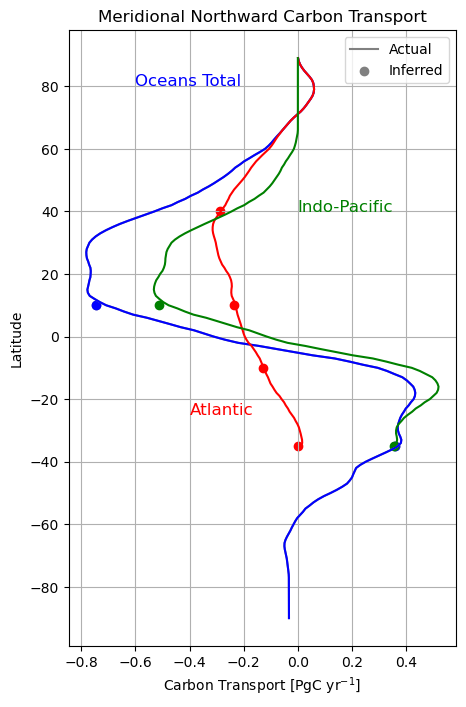

In [15]:
## Plot model carbon transports compared to MTM solution

Ctransp_global = xr.open_mfdataset('Cbudget_ECCO.nc').Ctransp_global
Ctransp_ATL = xr.open_mfdataset('Cbudget_ECCO.nc').Ctransp_ATL
Ctransp_INDPAC = xr.open_mfdataset('Cbudget_ECCO.nc').Ctransp_INDPAC

latgrid=np.arange(-90,90)

# Extract MTM solution section totals

Ctransp_global_MTM=np.zeros((2,1))
Ctransp_global_MTM[0]=(CF_section_tot[1]+CF_section_tot[8])
Ctransp_global_MTM[1]=(CF_section_tot[4]+CF_section_tot[6]+CF_section_tot[3])
lats_global=[10,-35]

Ctransp_ATL_MTM=np.zeros((4,1))
Ctransp_ATL_MTM[0]=(CF_section_tot[0]+CF_section_tot[9])
Ctransp_ATL_MTM[1]=(CF_section_tot[1]+CF_section_tot[9])
Ctransp_ATL_MTM[2]=(CF_section_tot[2]+CF_section_tot[9])
Ctransp_ATL_MTM[3]=(CF_section_tot[3]+CF_section_tot[9])
lats_ATL=[40,10,-10,-35]

Ctransp_INDPAC_MTM=np.zeros((2,1))
Ctransp_INDPAC_MTM[1]=(CF_section_tot[6]+CF_section_tot[4]-CF_section_tot[9])
Ctransp_INDPAC_MTM[0]=(CF_section_tot[8]-CF_section_tot[9])
lats_INDPAC=[10,-35]


yeardiff = (month_init_late-month_init_early).values/12
Ctransp2PgCperyr = 12*10**-18/yeardiff

# Plot

fs=12

plt.figure(figsize=(5,8))

plt.plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'grey')
plt.scatter(Ctransp_global_MTM,lats_global,c='grey')
plt.legend(['Actual','Inferred'])

plt.plot(-Ctransp_global*Ctransp2PgCperyr,latgrid,'b')
plt.scatter(Ctransp_global_MTM,lats_global,c='b')

plt.plot(-Ctransp_ATL*Ctransp2PgCperyr,latgrid,'r')
plt.scatter(Ctransp_ATL_MTM,lats_ATL,c='r')

plt.plot(-Ctransp_INDPAC*Ctransp2PgCperyr,latgrid,'g')
plt.scatter(Ctransp_INDPAC_MTM,lats_INDPAC,c='g')

plt.annotate('Oceans Total', (-0.6,80), color='b', fontsize=fs)
plt.annotate('Indo-Pacific', (0,40), color='g', fontsize=fs)
plt.annotate('Atlantic', (-0.4,-25), color='r', fontsize=fs)

plt.xlabel('Carbon Transport [PgC yr$^{-1}$]')
plt.ylabel('Latitude')
plt.grid()
plt.yticks(np.arange(-80,100,20))
plt.title('Meridional Northward Carbon Transport')

#plt.savefig(OTMrun+'_carbon_meridional_transport.png', bbox_inches='tight', dpi=300, transparent=True)             

In [16]:
## Calculate meridional divergence of inter-basin carbon transports

net_carbon_trans_Basins = [CF_section_tot[0]+CF_section_tot[9],\
    CF_section_tot[1]-CF_section_tot[0],\
        CF_section_tot[2]-CF_section_tot[1],\
            CF_section_tot[3]-CF_section_tot[2],\
                CF_section_tot[4]-CF_section_tot[5],\
                    CF_section_tot[6]-CF_section_tot[7],\
                        CF_section_tot[7]-CF_section_tot[8]+CF_section_tot[5],\
                            CF_section_tot[8]-CF_section_tot[9],\
                            -CF_section_tot[4]-CF_section_tot[6]-CF_section_tot[3]]

In [17]:
## Make table of carbon budget with model surface carbon flux

pd.options.display.float_format = '{:,.2f}'.format
d = {'Carbon Inventory Change [Pg-C/yr]': np.append(Cint_change, np.nansum(Cint_change)),\
    'Surface Carbon Flux (ECCO-Darwin) [Pg-C/yr]': np.append(Cflux_input, np.nansum(Cflux_input)),\
    'Net Meridional Carbon Transport [Pg-C/yr]': np.append(net_carbon_trans_Basins, np.nansum(net_carbon_trans_Basins)),\
        'Carbon Budget Residual [Pg-C/yr]': np.append(Cint_change-Cflux_input-net_carbon_trans_Basins, np.nansum(Cint_change-Cflux_input-net_carbon_trans_Basins))}    
table = pd.DataFrame(data=d, index=np.append(Basins, 'TOTAL'))
table

,Carbon Inventory Change [Pg-C/yr],Surface Carbon Flux (ECCO-Darwin) [Pg-C/yr],Net Meridional Carbon Transport [Pg-C/yr],Carbon Budget Residual [Pg-C/yr]
Polar N. Atlantic,0.24,0.53,-0.29,-0.00
Subtropical N. Atlantic,0.05,0.01,0.05,-0.01
Eq. Atlantic,0.02,-0.08,0.11,-0.00
S. Atlantic,0.13,0.01,0.13,-0.00
Indian,0.23,0.10,0.14,-0.01
S. Pacific,0.01,-0.01,0.03,-0.01
Eq. Pacific,0.15,-0.54,0.70,-0.00
N. Pacific,0.25,0.75,-0.51,0.01
Southern Ocean,0.79,1.18,-0.36,-0.03
TOTAL,1.88,1.94,0.00,-0.06


In [18]:
## Make table of carbon budget with MTM surface carbon flux

pd.options.display.float_format = '{:,.2f}'.format
d = {'Carbon Inventory Change [Pg-C/yr]': np.append(Cint_change, np.nansum(Cint_change)),\
    'Surface Carbon Flux (MTM) [Pg-C/yr]': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
    'Net Meridional Carbon Transport [Pg-C/yr]': np.append(net_carbon_trans_Basins, np.nansum(net_carbon_trans_Basins)),\
        'Carbon Budget Residual [Pg-C/yr]': np.append(Cint_change-dC_Cflux_int-dC_adj_int-net_carbon_trans_Basins, np.nansum(Cint_change-dC_Cflux_int-dC_adj_int-net_carbon_trans_Basins))}    
table = pd.DataFrame(data=d, index=np.append(Basins, 'TOTAL'))
table

,Carbon Inventory Change [Pg-C/yr],Surface Carbon Flux (MTM) [Pg-C/yr],Net Meridional Carbon Transport [Pg-C/yr],Carbon Budget Residual [Pg-C/yr]
Polar N. Atlantic,0.24,0.52,-0.29,0.00
Subtropical N. Atlantic,0.05,0.00,0.05,-0.00
Eq. Atlantic,0.02,-0.09,0.11,-0.00
S. Atlantic,0.13,0.00,0.13,0.00
Indian,0.23,0.09,0.14,-0.00
S. Pacific,0.01,-0.02,0.03,-0.00
Eq. Pacific,0.15,-0.55,0.70,-0.00
N. Pacific,0.25,0.76,-0.51,-0.00
Southern Ocean,0.79,1.14,-0.36,0.01
TOTAL,1.88,1.88,0.00,-0.00


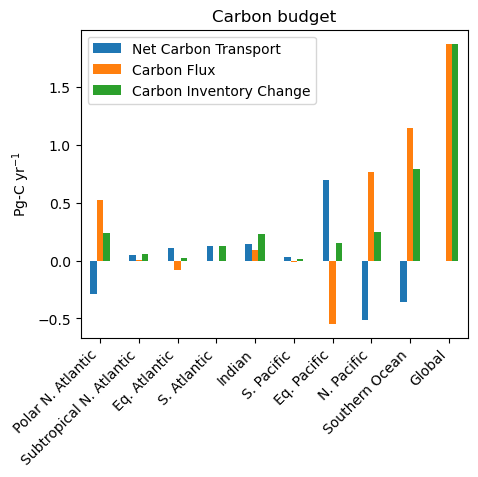

In [19]:
## Plot carbon budget with MTM surface carbon flux

from pandas import Series, DataFrame

df = pd.DataFrame({'Net Carbon Transport': np.append(net_carbon_trans_Basins, np.nansum(net_carbon_trans_Basins)),\
                   'Carbon Flux': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
                  'Carbon Inventory Change': np.append(Cint_change, np.nansum(Cint_change))},\
                  index = np.append(Basins, 'Global'))
ax = df.plot.bar(figsize=(5,4),rot=90)
plt.ylabel('Pg-C yr$^{-1}$')
plt.title('Carbon budget')

ax.set_xticks(np.arange(len(df.index)))  # Set tick positions
ax.set_xticklabels(df.index, rotation=45, ha="right")  # Use 'ha' to align right

plt.savefig(OTMrun+'_carbon_budget.png', bbox_inches='tight', dpi=300, transparent=True)                                      

### Section carbon transport streamfunctions in temperature space

In [20]:
section_names = np.array([r'40$^{\circ}$N (Atlantic)', 
                r'10$^{\circ}$N (Atlantic)',
                r'10$^{\circ}$S (Atlantic)', 
                r'35$^{\circ}$S (Atlantic)',
                r'35$^{\circ}$S (Indian)',
                r'110 - 100 $^{\circ}$E, 10 - 0 $^{\circ}$S (ITF)',
                r'35$^{\circ}$S (Pacific)',
                r'10$^{\circ}$S (Pacific)',
                r'10$^{\circ}$N (Pacific)'])


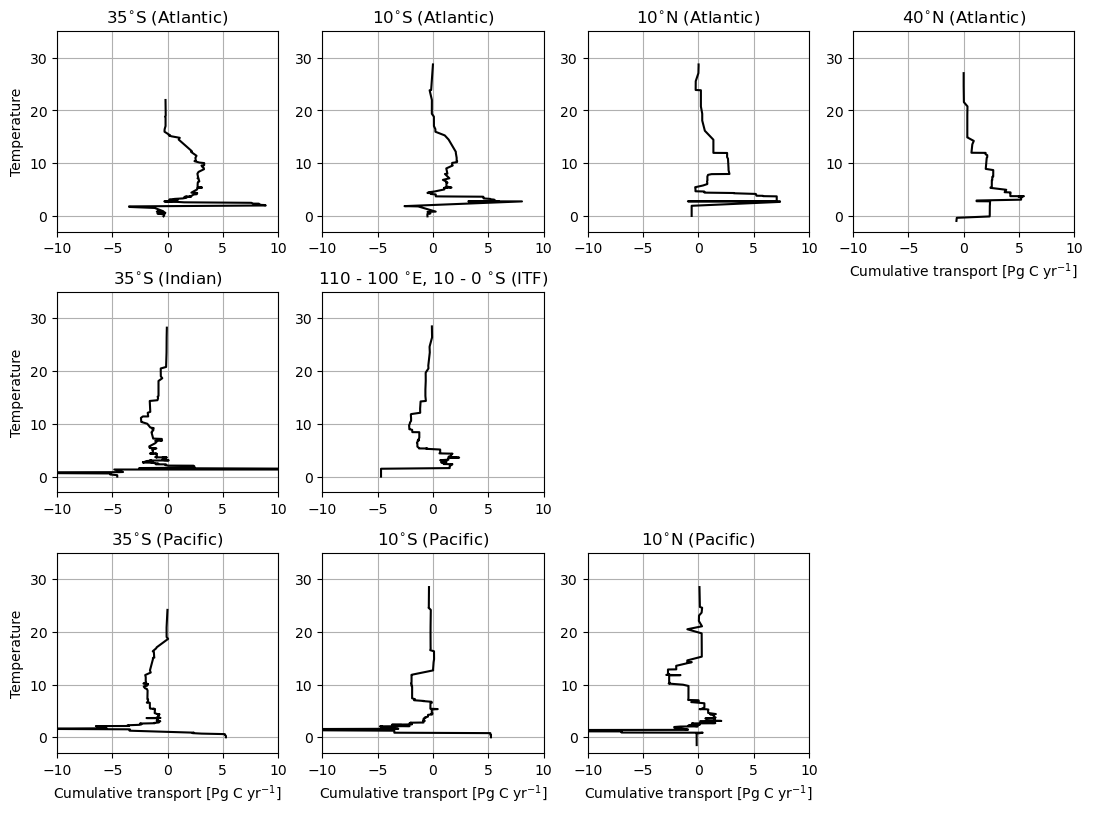

In [21]:
fig  = plt.figure(1, figsize = (17.5*0.75, 12.5*0.75))
gs = gridspec.GridSpec(3,4)
gs.update(wspace = 0.2, hspace=0.3)

ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), \
           plt.subplot(gs[0,1]), \
           plt.subplot(gs[0,2]) , \
           plt.subplot(gs[0,3])

ax5, ax6 = plt.subplot(gs[1,0]), \
           plt.subplot(gs[1,1])

ax7, ax8,ax9 = plt.subplot(gs[2,0]), \
           plt.subplot(gs[2,1]), \
            plt.subplot(gs[2,2])

xmin, xmax = -10, 10

ax1.plot(np.nancumsum(C_trans[3,:][np.argsort(T_joined[3,:])][::-1])[::-1], T_joined[3,:][np.argsort(T_joined[3,:])], '-k')
ax1.set_title(section_names[3])
ax1.set_ylim(-3,35)
ax1.set_xlim(xmin, xmax)

ax2.plot(np.nancumsum(C_trans[2,:][np.argsort(T_joined[2,:])][::-1])[::-1], T_joined[2,:][np.argsort(T_joined[2,:])], '-k')
ax2.set_title(section_names[2])
ax2.set_ylim(-3,35)
ax2.set_xlim(xmin, xmax)

ax3.plot(np.nancumsum(C_trans[1,:][np.argsort(T_joined[1,:])][::-1])[::-1], T_joined[1,:][np.argsort(T_joined[1,:])], '-k')
ax3.set_title(section_names[1])
ax3.set_ylim(-3,35)
ax3.set_xlim(xmin, xmax)

ax4.plot(np.nancumsum(C_trans[0,:][np.argsort(T_joined[0,:])][::-1])[::-1], T_joined[0,:][np.argsort(T_joined[0,:])], '-k')
ax4.set_title(section_names[0])
ax4.set_ylim(-3,35)
ax4.set_xlim(xmin, xmax)
ax4.set_xlabel('Cumulative transport [Pg C yr$^{-1}$]')

ax5.plot(np.nancumsum(C_trans[4,:][np.argsort(T_joined[4,:])][::-1])[::-1], T_joined[4,:][np.argsort(T_joined[4,:])], '-k')
ax5.set_title(section_names[4])
ax5.set_ylim(-3,35)
ax5.set_xlim(xmin, xmax)

ax6.plot(np.nancumsum(C_trans[5,:][np.argsort(T_joined[5,:])][::-1])[::-1], T_joined[5,:][np.argsort(T_joined[5,:])], '-k')
ax6.set_title(section_names[5])
ax6.set_ylim(-3,35)
ax6.set_xlim(xmin, xmax)

ax7.plot(np.nancumsum(C_trans[6,:][np.argsort(T_joined[6,:])][::-1])[::-1], T_joined[6,:][np.argsort(T_joined[6,:])], '-k')
ax7.set_title(section_names[6])
ax7.set_ylim(-3,35)
ax7.set_xlim(xmin, xmax)
ax7.set_xlabel('Cumulative transport [Pg C yr$^{-1}$]')

ax8.plot(np.nancumsum(C_trans[7,:][np.argsort(T_joined[7,:])][::-1])[::-1], T_joined[7,:][np.argsort(T_joined[7,:])], '-k')
ax8.set_title(section_names[7])
ax8.set_ylim(-3,35)
ax8.set_xlim(xmin, xmax)
ax8.set_xlabel('Cumulative transport [Pg C yr$^{-1}$]')

ax9.plot(np.nancumsum(C_trans[8,:][np.argsort(T_joined[8,:])][::-1])[::-1], T_joined[8,:][np.argsort(T_joined[8,:])], '-k')
ax9.set_title(section_names[8])
ax9.set_ylim(-3,35)
ax9.set_xlim(xmin, xmax)
ax9.set_xlabel('Cumulative transport [Pg C yr$^{-1}$]')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()
ax9.grid()

ax1.set_ylabel('Temperature')
ax5.set_ylabel('Temperature')
ax7.set_ylabel('Temperature')

#plt.savefig(OTMrun+'_carbon_Transport_SFs.png', bbox_inches='tight', dpi=300)

plt.show()

### Surface fluxes

In [22]:
dC_adj_int

array([ 0.00022258,  0.00024644, -0.00173095, -0.0022231 , -0.00590803,
       -0.00813056, -0.00539055,  0.0050543 , -0.02505747])

In [23]:
np.zeros(dC_adj_int.size)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

[Text(0, 0, 'Polar N. Atlantic'),
 Text(1, 0, 'Subtropical N. Atlantic'),
 Text(2, 0, 'Eq. Atlantic'),
 Text(3, 0, 'S. Atlantic'),
 Text(4, 0, 'Indian'),
 Text(5, 0, 'S. Pacific'),
 Text(6, 0, 'Eq. Pacific'),
 Text(7, 0, 'N. Pacific'),
 Text(8, 0, 'Southern Ocean'),
 Text(9, 0, 'Global')]

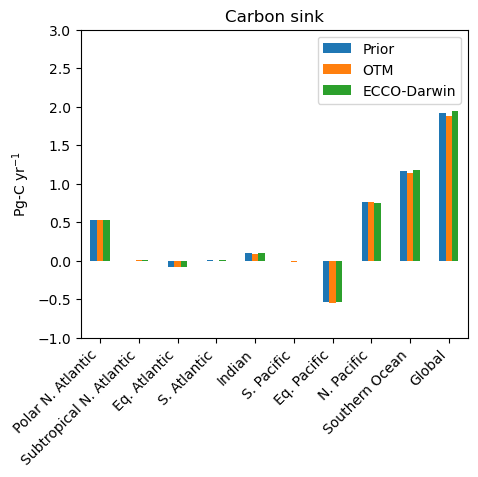

In [24]:
## Raw results

if CO2flux_prior:

    df = pd.DataFrame({'Prior': np.append(dC_Cflux_int, np.nansum(dC_Cflux_int)),\
                        'OTM': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
                       'ECCO-Darwin': np.append(Cflux_input, np.nansum(Cflux_input))},\
                      index = np.append(Basins, 'Global'))
    
else:
    df = pd.DataFrame({'Prior': np.append(np.zeros(dC_adj_int.size),0),\
                        'OTM': np.append(dC_Cflux_int+dC_adj_int, np.nansum(dC_Cflux_int+dC_adj_int)),\
                       'ECCO-Darwin': np.append(Cflux_input, np.nansum(Cflux_input))},\
                      index = np.append(Basins, 'Global'))
    

ax = df.plot.bar(figsize=(5,4),rot=90)
plt.ylabel('Pg-C yr$^{-1}$')
plt.title('Carbon sink')
plt.ylim(-1,3)

ax.set_xticks(np.arange(len(df.index)))  # Set tick positions
ax.set_xticklabels(df.index, rotation=45, ha="right")  # Use 'ha' to align right
#plt.savefig(OTMrun+'_carbon_sink.png', bbox_inches='tight', dpi=300, transparent=True)